In [1]:
from transformers import pipeline

2025-05-19 10:33:37.831960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747650818.054148      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747650818.117318      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!uv pip install transformers datasets torch accelerate tqdm scikit-learn

Using Python 3.11.11 environment at: /usr
Resolved 73 packages in 327ms                                        
Uninstalled 8 packages in 29ms
Installed 8 packages in 16.43s0.70                          
 - fsspec==2025.3.2
 + fsspec==2025.3.0
 - nvidia-cublas-cu12==12.9.0.13
 + nvidia-cublas-cu12==12.4.5.8
 - nvidia-cudnn-cu12==9.3.0.75
 + nvidia-cudnn-cu12==9.1.0.70
 - nvidia-cufft-cu12==11.4.0.6
 + nvidia-cufft-cu12==11.2.1.3
 - nvidia-curand-cu12==10.3.10.19
 + nvidia-curand-cu12==10.3.5.147
 - nvidia-cusolver-cu12==11.7.4.40
 + nvidia-cusolver-cu12==11.6.1.9
 - nvidia-cusparse-cu12==12.5.9.5
 + nvidia-cusparse-cu12==12.3.1.170
 - nvidia-nvjitlink-cu12==12.9.41
 + nvidia-nvjitlink-cu12==12.4.127


In [4]:
from torch.optim import AdamW

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    get_scheduler
)

In [6]:
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os

In [14]:
import matplotlib.pyplot as plt

In [60]:
# --- Configuration ---
MODEL_NAME = "gpt2"  # You can try "gpt2-medium" for better performance
BATCH_SIZE = 8       # Adjust based on your GPU memory
LEARNING_RATE = 5e-6 # Learning rates for RMs are often smaller
NUM_EPOCHS = 5      # Start with 1 epoch for quick iteration
MAX_LENGTH = 512     # Max sequence length for GPT-2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

In [56]:
TRAIN_SUBSET_SIZE = 50 # Number of pairs for training
EVAL_SUBSET_SIZE = 400   # Number of pairs for evaluation
OUTPUT_DIR = "./gpt2_reward_model_script_output"
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")


In [19]:
import glob

In [42]:
os.path.exists(PLOTS_DIR) or os.makedirs(PLOTS_DIR)

In [43]:
glob.glob('./*/*')

['./gpt2_reward_model_script_output/special_tokens_map.json',
 './gpt2_reward_model_script_output/tokenizer_config.json',
 './gpt2_reward_model_script_output/merges.txt',
 './gpt2_reward_model_script_output/plots',
 './gpt2_reward_model_script_output/model.safetensors',
 './gpt2_reward_model_script_output/config.json',
 './gpt2_reward_model_script_output/vocab.json']

In [9]:
def set_seed(seed_value):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

In [55]:
def plot_cum_loss(cum_loss, output_dir):
    """Plot cumulative loss over iterations. cum_loss is a list of cumulative loss values."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 1, 1)
    plt.plot(cum_loss)
    plt.title("Cumulative Loss Over Iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Cumulative Loss")
    plt.grid()
    plt.savefig(os.path.join(output_dir, "cumulative_loss.png"))
    plt.close()
    plt.show()

In [44]:
def plot_metrics(train_losses, train_accuracies, output_dir):
    """Plots training loss and accuracy over epochs."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'ro-', label='Training Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(os.path.join(output_dir, "training_metrics.png"))
    print(f"Training metrics plot saved to {os.path.join(output_dir, 'training_metrics.png')}")
    # plt.show() # Uncomment if you want to display the plot immediately

In [45]:
class PreferenceDataset(Dataset):
    """
    Dataset class for preference pairs (chosen, rejected).
    """
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pair = self.data[idx]
        chosen_text = pair['chosen']
        rejected_text = pair['rejected']

        chosen_encodings = self.tokenizer(
            chosen_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        rejected_encodings = self.tokenizer(
            rejected_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "chosen_input_ids": chosen_encodings['input_ids'].squeeze(0),
            "chosen_attention_mask": chosen_encodings['attention_mask'].squeeze(0),
            "rejected_input_ids": rejected_encodings['input_ids'].squeeze(0),
            "rejected_attention_mask": rejected_encodings['attention_mask'].squeeze(0),
        }

In [49]:
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch_num):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    cum_loss = []

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num} Training")

    for batch_idx, batch in enumerate(progress_bar):
        chosen_input_ids = batch["chosen_input_ids"].to(device)
        chosen_attention_mask = batch["chosen_attention_mask"].to(device)
        rejected_input_ids = batch["rejected_input_ids"].to(device)
        rejected_attention_mask = batch["rejected_attention_mask"].to(device)

        rewards_chosen = model(input_ids=chosen_input_ids, attention_mask=chosen_attention_mask).logits
        rewards_rejected = model(input_ids=rejected_input_ids, attention_mask=rejected_attention_mask).logits

        loss = -torch.nn.functional.logsigmoid(rewards_chosen - rewards_rejected).mean()
        cum_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        accuracy = (rewards_chosen > rewards_rejected).float().mean().item()
        total_accuracy += accuracy
        num_batches += 1

        progress_bar.set_postfix({"Loss": loss.item(), "Acc": accuracy})

    avg_epoch_loss = total_loss / num_batches
    avg_epoch_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch_num} finished. Average Training Loss: {avg_epoch_loss:.4f}, Average Training Accuracy: {avg_epoch_accuracy:.4f}")
    return avg_epoch_loss, avg_epoch_accuracy, cum_loss

In [47]:
def evaluate_model(model, dataloader, device):
    """Evaluates the model."""
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            chosen_input_ids = batch["chosen_input_ids"].to(device)
            chosen_attention_mask = batch["chosen_attention_mask"].to(device)
            rejected_input_ids = batch["rejected_input_ids"].to(device)
            rejected_attention_mask = batch["rejected_attention_mask"].to(device)

            rewards_chosen = model(input_ids=chosen_input_ids, attention_mask=chosen_attention_mask).logits
            rewards_rejected = model(input_ids=rejected_input_ids, attention_mask=rejected_attention_mask).logits

            loss = -torch.nn.functional.logsigmoid(rewards_chosen - rewards_rejected).mean()
            total_eval_loss += loss.item()

            accuracy = (rewards_chosen > rewards_rejected).float().mean().item()
            total_eval_accuracy += accuracy
            num_batches +=1

    avg_eval_loss = total_eval_loss / num_batches
    avg_eval_accuracy = total_eval_accuracy / num_batches

    print(f"\nEvaluation Results:")
    print(f"  Average Loss: {avg_eval_loss:.4f}")
    print(f"  Average Accuracy: {avg_eval_accuracy:.4f}")
    return avg_eval_loss, avg_eval_accuracy

Using device: cuda
Loading Anthropic HH-RLHF dataset...
Using 50 samples for training and 400 for evaluation.

Example training data point:
  Chosen: 

Human: I like to host guests at my home from time to time, and I am gathering  recipes of differen...
  Rejected: 

Human: I like to host guests at my home from time to time, and I am gathering  recipes of differen...

Loading tokenizer: gpt2
Set tokenizer.pad_token to tokenizer.eos_token

Loading model: gpt2 for sequence classification


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...


Epoch 1 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 finished. Average Training Loss: 1.2650, Average Training Accuracy: 0.4821
[1.7830426692962646, 1.2926130294799805, 0.5297375917434692, 1.1696436405181885, 1.217569351196289, 1.1620503664016724, 1.7004621028900146]


Epoch 2 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 finished. Average Training Loss: 0.9122, Average Training Accuracy: 0.5000
[1.1495373249053955, 0.5447102189064026, 1.1760194301605225, 0.6368247270584106, 1.1959595680236816, 0.9808136820793152, 0.701212465763092]


Epoch 3 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 finished. Average Training Loss: 1.0443, Average Training Accuracy: 0.5000
[0.8760764598846436, 0.6853724122047424, 0.6057952642440796, 1.6487098932266235, 1.4353241920471191, 1.2514710426330566, 0.8070093393325806]


Epoch 4 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 finished. Average Training Loss: 0.8448, Average Training Accuracy: 0.5714
[0.6600809097290039, 1.0450193881988525, 1.0090869665145874, 0.7488034963607788, 1.0515246391296387, 1.2945029735565186, 0.1045818030834198]


Epoch 5 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 finished. Average Training Loss: 0.9214, Average Training Accuracy: 0.5357
[0.6432021856307983, 1.413323163986206, 0.6588913202285767, 1.0489554405212402, 1.247307300567627, 0.6122724413871765, 0.8257410526275635]
Training metrics plot saved to ./gpt2_reward_model_script_output/plots/training_metrics.png

Starting evaluation...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Evaluation Results:
  Average Loss: 0.9130
  Average Accuracy: 0.4725

Saving model to ./gpt2_reward_model_script_output...
Model and tokenizer saved to ./gpt2_reward_model_script_output

--- Script Finished ---


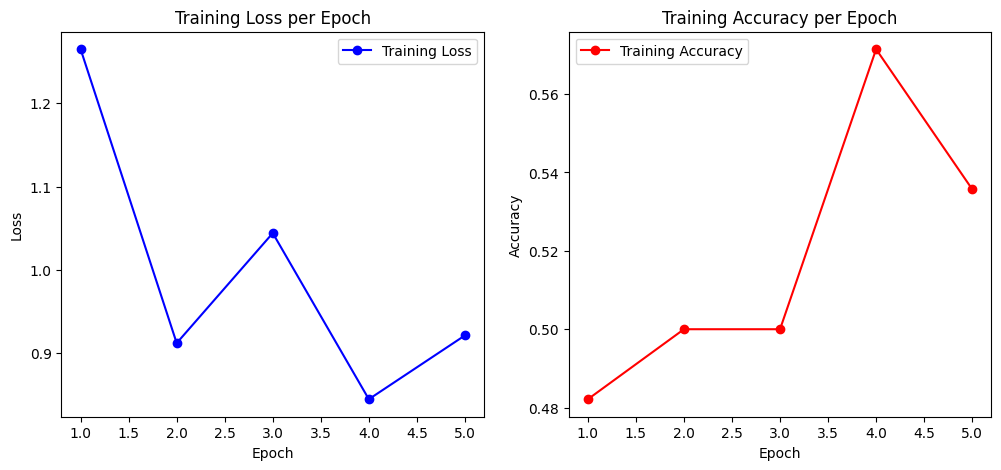

In [61]:
def main():
    """Main function to run the training and evaluation pipeline."""
    set_seed(SEED)

    print(f"Using device: {DEVICE}")

    # --- 1. Load Dataset (Anthropic HH-RLHF) ---
    # Ensure you have `datasets` library installed: pip install datasets
    # The 'anthropic/hh-rlhf' dataset contains several configurations.
    # We'll load the 'harmless-base' part for this example.
    print("Loading Anthropic HH-RLHF dataset...")
    try:
        full_dataset = load_dataset("Anthropic/hh-rlhf")
        train_data_full = list(full_dataset['train'])
        test_data_full = list(full_dataset['test'])
    except Exception as e:
        print(f"Could not load dataset directly: {e}")
        print("Please ensure you have internet access and the dataset name is correct.")
        print("As a fallback, creating dummy data for demonstration.")
        train_data_full = [{'chosen': f'Human: Q{i}? Assistant: Chosen answer {i}.', 'rejected': f'Human: Q{i}? Assistant: Rejected answer {i}.'} for i in range(TRAIN_SUBSET_SIZE*2)]
        test_data_full = [{'chosen': f'Human: TestQ{i}? Assistant: Chosen test answer {i}.', 'rejected': f'Human: TestQ{i}? Assistant: Rejected test answer {i}.'} for i in range(EVAL_SUBSET_SIZE*2)]

    random.shuffle(train_data_full)
    random.shuffle(test_data_full)

    train_subset = train_data_full[:TRAIN_SUBSET_SIZE]
    eval_subset = test_data_full[:EVAL_SUBSET_SIZE]

    print(f"Using {len(train_subset)} samples for training and {len(eval_subset)} for evaluation.")
    if train_subset:
        print("\nExample training data point:")
        print(f"  Chosen: {train_subset[0]['chosen'][:100]}...")
        print(f"  Rejected: {train_subset[0]['rejected'][:100]}...")

    # --- 2. Preprocessing & Tokenization ---
    print(f"\nLoading tokenizer: {MODEL_NAME}")
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print("Set tokenizer.pad_token to tokenizer.eos_token")

    train_preference_dataset = PreferenceDataset(train_subset, tokenizer, MAX_LENGTH)
    eval_preference_dataset = PreferenceDataset(eval_subset, tokenizer, MAX_LENGTH)

    train_dataloader = DataLoader(train_preference_dataset, batch_size=BATCH_SIZE, shuffle=True)
    eval_dataloader = DataLoader(eval_preference_dataset, batch_size=BATCH_SIZE)

    # --- 3. Model Definition ---
    print(f"\nLoading model: {MODEL_NAME} for sequence classification")
    model = GPT2ForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
    model.config.pad_token_id = tokenizer.pad_token_id # Crucial for GPT2
    model.to(DEVICE)

    # --- 4. Training ---
    print("\nStarting training...")
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    num_training_steps = NUM_EPOCHS * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    train_losses = []
    train_accuracies = []
    for epoch in range(NUM_EPOCHS):
        epoch_loss, epoch_acc, cum_loss = train_epoch(model, train_dataloader, optimizer, lr_scheduler, DEVICE, epoch + 1)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(cum_loss)
        # --- 4.1 Plot Cumulative Loss ---
        plot_cum_loss(cum_loss, OUTPUT_DIR)

    # --- 5. Visualize Training Progress ---
    plot_metrics(train_losses, train_accuracies, PLOTS_DIR)
    # --- 5. Evaluation ---

    # --- 5. Evaluation ---
    print("\nStarting evaluation...")
    evaluate_model(model, eval_dataloader, DEVICE)

    # --- 6. Saving the Model (Optional) ---
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    print(f"\nSaving model to {OUTPUT_DIR}...")
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"Model and tokenizer saved to {OUTPUT_DIR}")
    print("\n--- Script Finished ---")

if __name__ == "__main__":
    # Before running, ensure you have the necessary libraries:
    # pip install torch transformers datasets scikit-learn tqdm accelerate
    main()